# Picola training data demonstration

## This notebook demonstrates the steps to go from a healpix $\kappa$ map to the DES SV training data

In [1]:
%matplotlib inline
import numpy as np
import random
import time
from scipy import fftpack
import os, sys
import pandas as pd
import scipy.ndimage as ndimage
import healpy as hp
from astropy.io import fits
from importlib import reload 

import matplotlib.pyplot as plt

# sys path prepend and reload are for development
sys.path = ['../'] + sys.path
print(sys.path)

['../', '', '/Users/ucapnje/anaconda3/lib/python36.zip', '/Users/ucapnje/anaconda3/lib/python3.6', '/Users/ucapnje/anaconda3/lib/python3.6/lib-dynload', '/Users/ucapnje/.local/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/pydelfi-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/deepmass-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/ucapnje/.ipython']


In [2]:
# sys path prepend and reload are for development

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener

reload(mf)
reload(ld)
reload(wiener)

<module 'deepmass.wiener' from '../deepmass/wiener.py'>

In [3]:
example_picola_file = '../../peaks/l-picola_peak_statistics/kappaA/kappa_nicaea_rescaled/kappa_nicaea24.fits'
picola_example = hp.read_map(example_picola_file, verbose=False)

In [4]:
reduced_nside = 1024
msk=np.zeros(hp.nside2npix(reduced_nside))
th,ph=hp.pix2ang(reduced_nside,np.arange(hp.nside2npix(reduced_nside)))
ph[np.where(ph>np.pi)[0]]-=2*np.pi
msk[np.where((th<np.pi*0.5) & (ph>0) & (ph<np.pi*0.5))[0]]=1.

In [5]:
picola_example_masked = np.where(msk>0.5, picola_example, hp.UNSEEN)

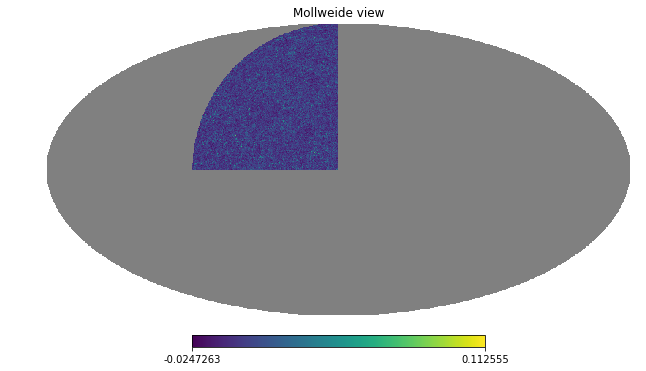

In [6]:
hp.mollview(picola_example_masked)

# Take a patch and calculate shear

In [7]:
patch = ld.random_map(picola_example_masked)

In [8]:
A_ft_diagonal = ld.ks_fourier_matrix(256)
shear = ld.ks_inv(patch, A_ft_diagonal)
patch_test = ld.ks(shear, A_ft_diagonal) 
print('Biggest pixel difference = ' + str(np.max(np.abs(patch-patch_test))))

Biggest pixel difference = 2.111737713161702e-17


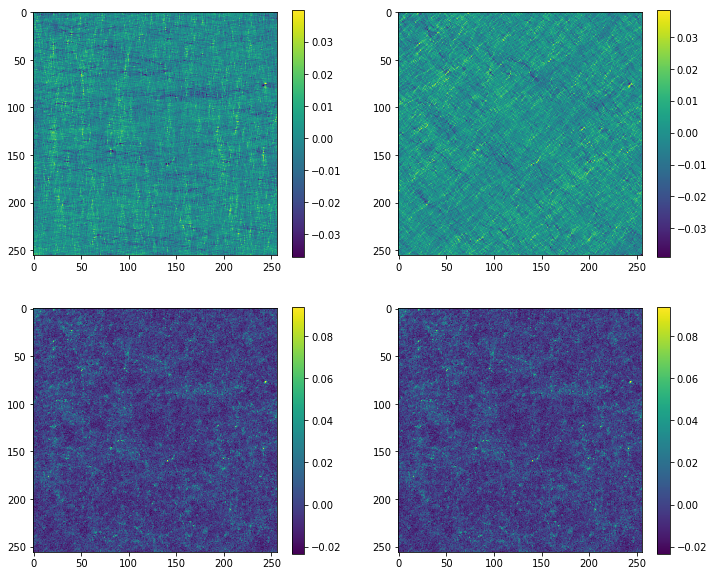

In [9]:
_ = plt.figure(figsize =(12,10))
_ = plt.subplot(2,2,1)
_ = plt.imshow(shear.real), plt.colorbar()
_ = plt.subplot(2,2,2)
_ = plt.imshow(shear.imag), plt.colorbar()
_ = plt.subplot(2,2,3)
_ = plt.imshow(patch_test.real), plt.colorbar()
_ = plt.subplot(2,2,4)
_ = plt.imshow(patch), plt.colorbar()

# Add mask and noise

In [10]:
input_file_des = '../mice_mock/cat_DES_SV_zmean_final.fits'
hdu_des =  fits.open(input_file_des)
print(hdu_des.info())
des_cat = hdu_des[1].data
print(des_cat.columns)

Filename: ../mice_mock/cat_DES_SV_zmean_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   1628663R x 9C   [D, D, D, D, D, D, D, D, D]   
None
ColDefs(
    name = 'ra_gal'; format = 'D'
    name = 'dec_gal'; format = 'D'
    name = 'zmean'; format = 'D'
    name = 'e1_gal'; format = 'D'
    name = 'e2_gal'; format = 'D'
    name = 'e1_gal_sens'; format = 'D'
    name = 'e2_gal_sens'; format = 'D'
    name = 'coad_id'; format = 'D'
    name = 'sens_avg'; format = 'D'
)


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


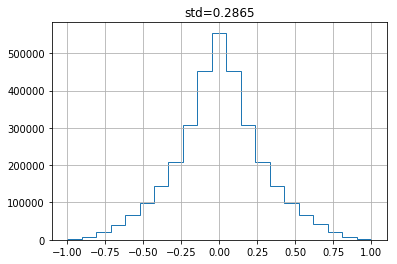

In [11]:
des_galaxy_shapes = np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')])
std_e1 = np.std(des_galaxy_shapes)
_ = plt.hist(np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')]),
             histtype='step', bins=np.linspace(-1,1,22))
title = str('std=' + str(std_e1)[:6])
_ = plt.title(title), plt.grid('True')

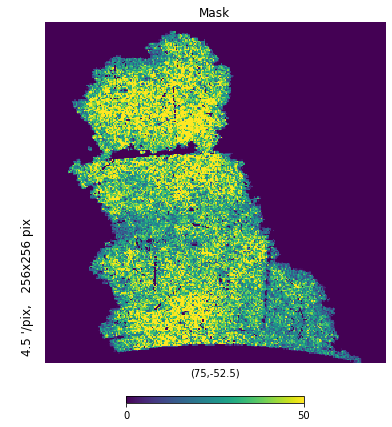

In [12]:
pixels= hp.ang2pix(reduced_nside,theta = 0.5*np.pi - np.deg2rad(des_cat.field('dec_gal')),
                   phi = np.deg2rad(des_cat.field('ra_gal')))
count_map = np.bincount(pixels, minlength = hp.nside2npix(reduced_nside))
count_gnomview= hp.gnomview(count_map, rot=[+75.0,-52.5],  title='Mask', 
                min = 0, max=50, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)


In [13]:
sv_mask = np.where(count_gnomview<1,0.,1.)
g1_masked = sv_mask*shear.real
g2_masked = sv_mask*shear.imag

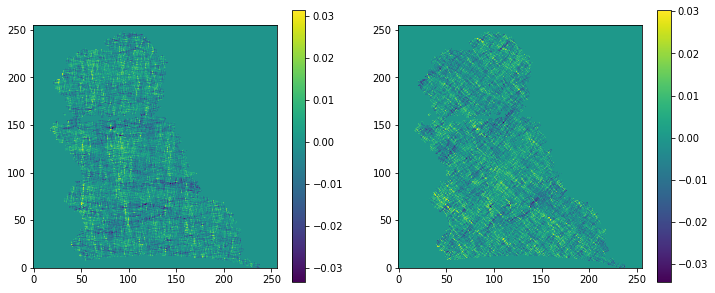

In [14]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(g1_masked, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(g2_masked, origin='lower'), plt.colorbar()

In [15]:
e1_des_noise, e2_des_noise = ld.shape_noise_realisation(des_cat.field('ra_gal'),
                                                     des_cat.field('dec_gal'),
                                                     des_cat.field('e1_gal_sens'),
                                                     des_cat.field('e2_gal_sens'),
                                                     reduced_nside)


../deepmass/lens_data.py:38: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(bincount > 0.5, bincount_weighted / bincount, hp.UNSEEN)
../deepmass/lens_data.py:38: RuntimeWarning: invalid value encountered in true_divide
  return np.where(bincount > 0.5, bincount_weighted / bincount, hp.UNSEEN)


In [16]:
e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

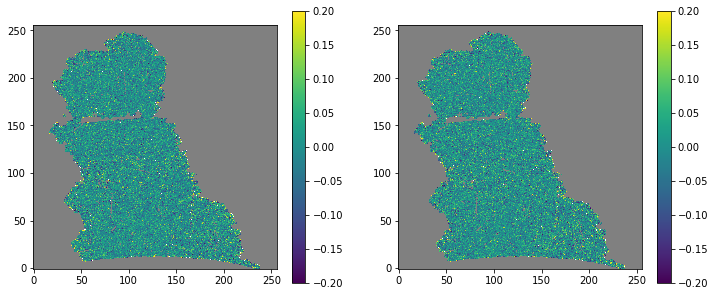

In [17]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_noise_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_noise_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

In [18]:
e1_noisy = np.where(e1_noise_map.mask==False,  e1_noise_map + shear.real, 0.)
e2_noisy = np.where(e2_noise_map.mask==False,  e2_noise_map + shear.imag, 0.)

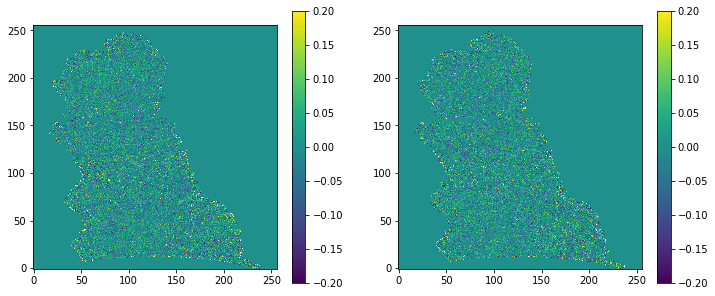

In [19]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_noisy, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_noisy, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

# Do Kaiser-Squires

In [20]:
ks_map = ld.ks(e1_noisy + 1j*e2_noisy, A_ft_diagonal)

In [21]:
ks_smoothed = ndimage.gaussian_filter(ks_map.real, sigma=2.)
smoothed_truth = ndimage.gaussian_filter(patch.real, sigma=0.5)

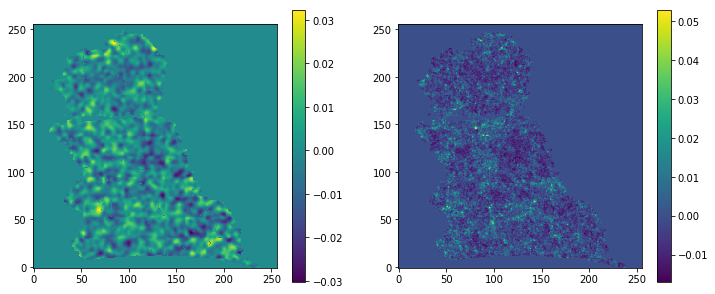

In [22]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed*sv_mask, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(smoothed_truth*sv_mask, origin='lower', interpolation='none'), plt.colorbar()

# Wiener filtering

In [23]:
# compute the power spectrum 
fft2D = np.fft.fft2(patch.real)
psd1D_kmt = mf.radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))
# ps_map_empirical = mf.compute_spectrum_map(psd1D_kmt,256)

In [25]:
# np.save('../picola_training/temp_wiener_power_fiducial', ps_map_empirical)

In [26]:
power_proj_y1_cosmo = fits.open('DES_SV_proj_y1_cosmo.fits')
power_proj_y1_cosmo = power_proj_y1_cosmo[0].data

In [42]:
np.save('../picola_training/power_map_y1_fiducial', power_map)

/Users/ucapnje/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


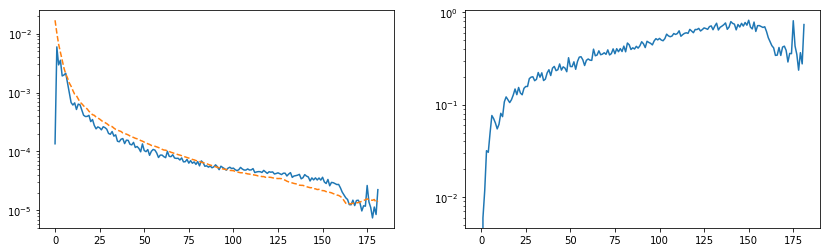

In [27]:
_ = plt.figure(figsize=(14,4))
k_axis = np.arange(len(psd1D_kmt))
_ = plt.subplot(1,2,1), plt.plot(k_axis,psd1D_kmt), plt.yscale('log')
_ = plt.subplot(1,2,1), plt.plot(k_axis,power_proj_y1_cosmo, '--'), plt.yscale('log')
_ = plt.subplot(1,2,2), plt.plot(k_axis, k_axis*k_axis*psd1D_kmt), plt.yscale('log')

In [28]:
power_map = mf.compute_spectrum_map(psd1D_kmt,256)

In [29]:
Ncov = np.where(count_gnomview>0.0, 2.0 * std_e1 * std_e1 / count_gnomview, 1e18)
np.save('../picola_training/Ncov', Ncov)

/Users/ucapnje/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [43]:
wiener_result500, _ = wiener.filtering(e1_noisy, e2_noisy, power_map, Ncov)
wiener_result30, _  = wiener.filtering(e1_noisy, e2_noisy, power_map, Ncov, 30)
wiener_result15, _  = wiener.filtering(e1_noisy, e2_noisy, power_map, Ncov, 20)
wiener_result5, _ = wiener.filtering(e1_noisy,e2_noisy, power_map, Ncov, 5)

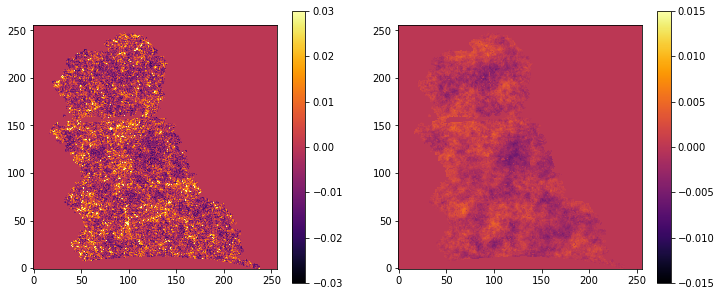

In [44]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(patch*sv_mask, origin='lower', vmin = -0.03,  vmax = 0.03, cmap = 'inferno'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(wiener_result500*sv_mask, origin='lower', vmin = -0.015, vmax = 0.015, cmap = 'inferno')
_ = plt.colorbar()

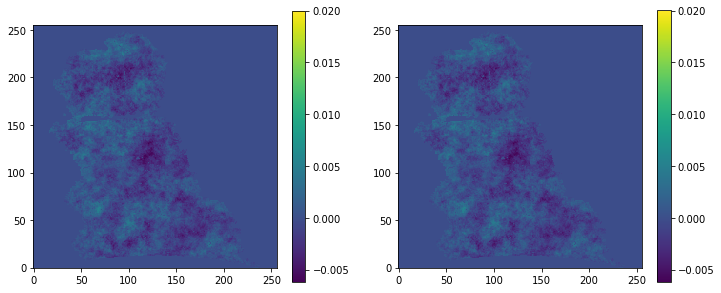

In [45]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(wiener_result30.real*sv_mask, origin='lower', vmax = 0.02), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(wiener_result500.real*sv_mask, origin='lower', vmax = 0.02), plt.colorbar()

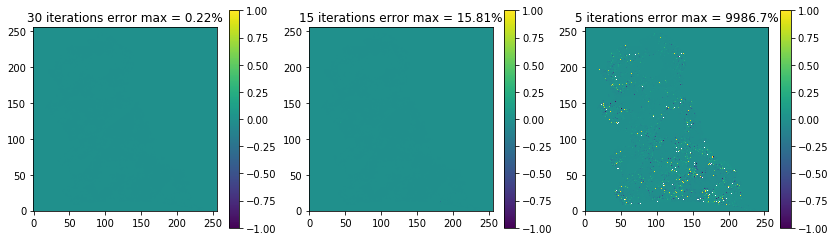

In [46]:
_ = plt.figure(figsize =(14,4))
_ = plt.subplot(1,3,1)
error = (wiener_result30.real - wiener_result500.real)*sv_mask/wiener_result500.real
_ = plt.title('30 iterations error max = ' +str(100.*np.max(np.abs(error)))[:4] + '%')
_ = plt.imshow((wiener_result30.real  - wiener_result500.real)*sv_mask/(wiener_result500.real),
               origin='lower', clim=(-1,1)), plt.colorbar()
_ = plt.subplot(1,3,2)
error = (wiener_result15.real - wiener_result500.real)*sv_mask/wiener_result500.real
_ = plt.title('15 iterations error max = ' +str(100.*np.max(np.abs(error)))[:5] + '%')
_ = plt.imshow((wiener_result15.real  - wiener_result500.real)*sv_mask/(wiener_result500.real),
               origin='lower', clim=(-1,1)), plt.colorbar()
_ = plt.subplot(1,3,3)
error = (wiener_result5.real - wiener_result500.real)*sv_mask/wiener_result500.real
_ = plt.title('5 iterations error max = ' +str(100.*np.max(np.abs(error)))[:6] + '%')
_ = plt.imshow((wiener_result5.real  - wiener_result500.real)*sv_mask/(wiener_result500.real),
               origin='lower', clim=(-1,1)), plt.colorbar()


# Make a function do everything

In [49]:
t = time.time()
mf.generate_sv_maps(example_picola_file,
                    input_file_des,
                    '../picola_training/test_outputs/output_nj',
                    n_outputs = 5, power = power_map, Ncov=Ncov, fast_noise=False)

print(time.time() -t)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
mask calc
0

saving outputs 

71.58959007263184


In [50]:
test_ks = np.load('../picola_training/test_outputs/output_nj_KS.npy')
test_true = np.load('../picola_training/test_outputs/output_nj_kappa_true.npy')
test_wiener = np.load('../picola_training/test_outputs/output_nj_wiener.npy')

In [51]:
x = np.where(np.sum(test_ks[:,:,:,:] , axis = (1,2,3)) < -1e20)
mask_bad_data = np.ones(test_ks[:,0,0,0].shape,dtype=np.bool)
print(len(x[0]), x)
mask_bad_data[x] = False

0 (array([], dtype=int64),)


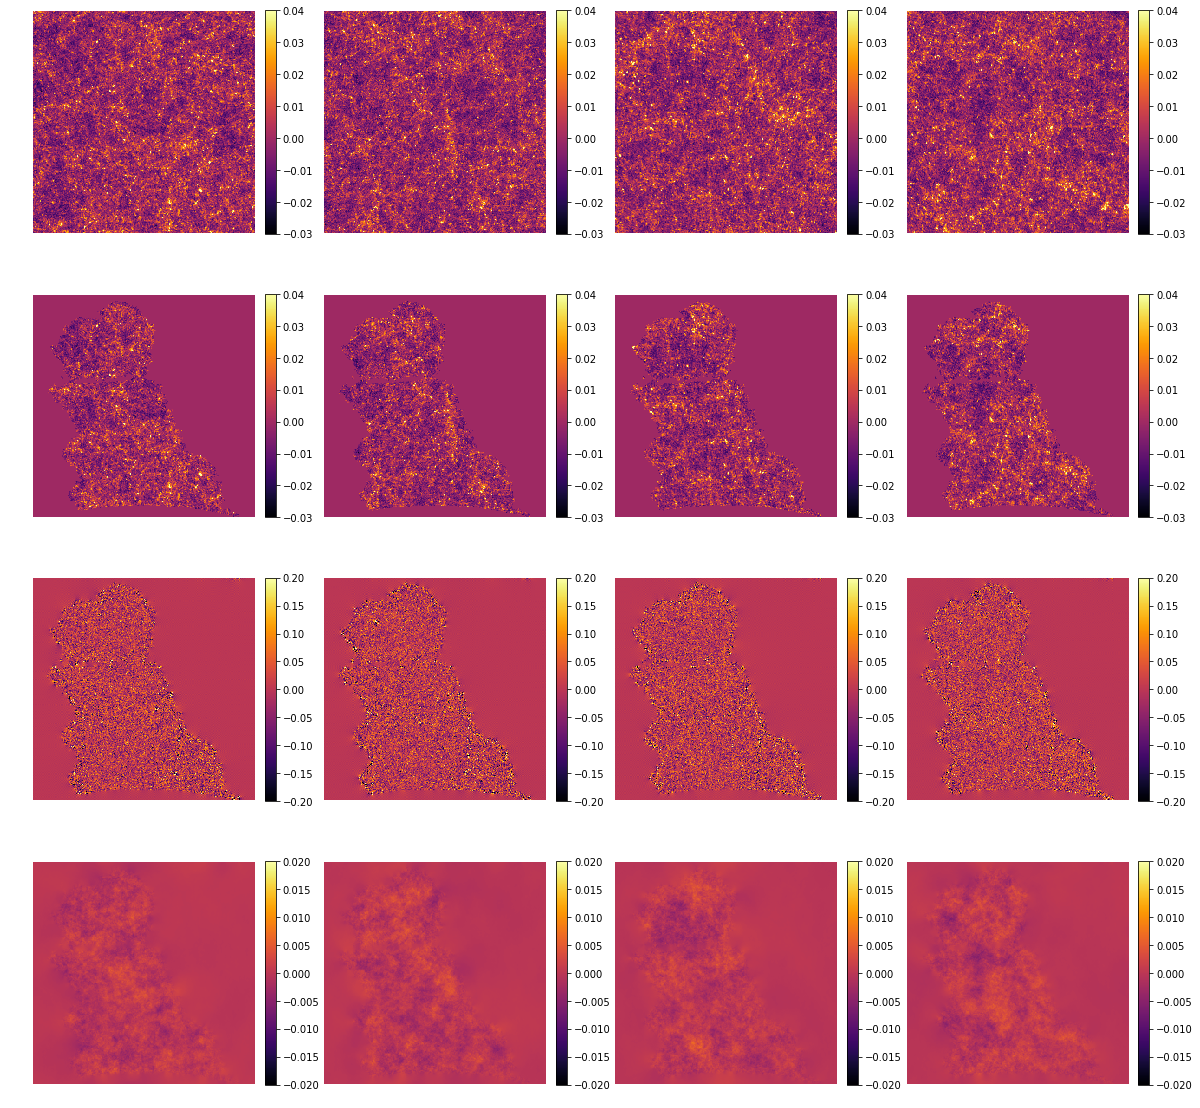

In [52]:
n = 4  # how many images displayed

plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    plt.subplot(4, n, i + 1)
    
    plt.imshow(test_true[i,:,:,0], origin = 'lower', cmap = 'inferno', clim= (-0.03,0.04))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + n)
    plt.imshow(test_true[i,:,:,0]*sv_mask, origin = 'lower', cmap = 'inferno', clim= (-0.03,0.04))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(test_ks[i,:,:,0], cmap = 'inferno', origin = 'lower', clim= (-0.2,0.2))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(test_wiener[i,:,:,0], cmap = 'inferno', origin = 'lower', clim= (-0.02,0.02))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    

plt.savefig('picola_training_data.pdf')
plt.show()

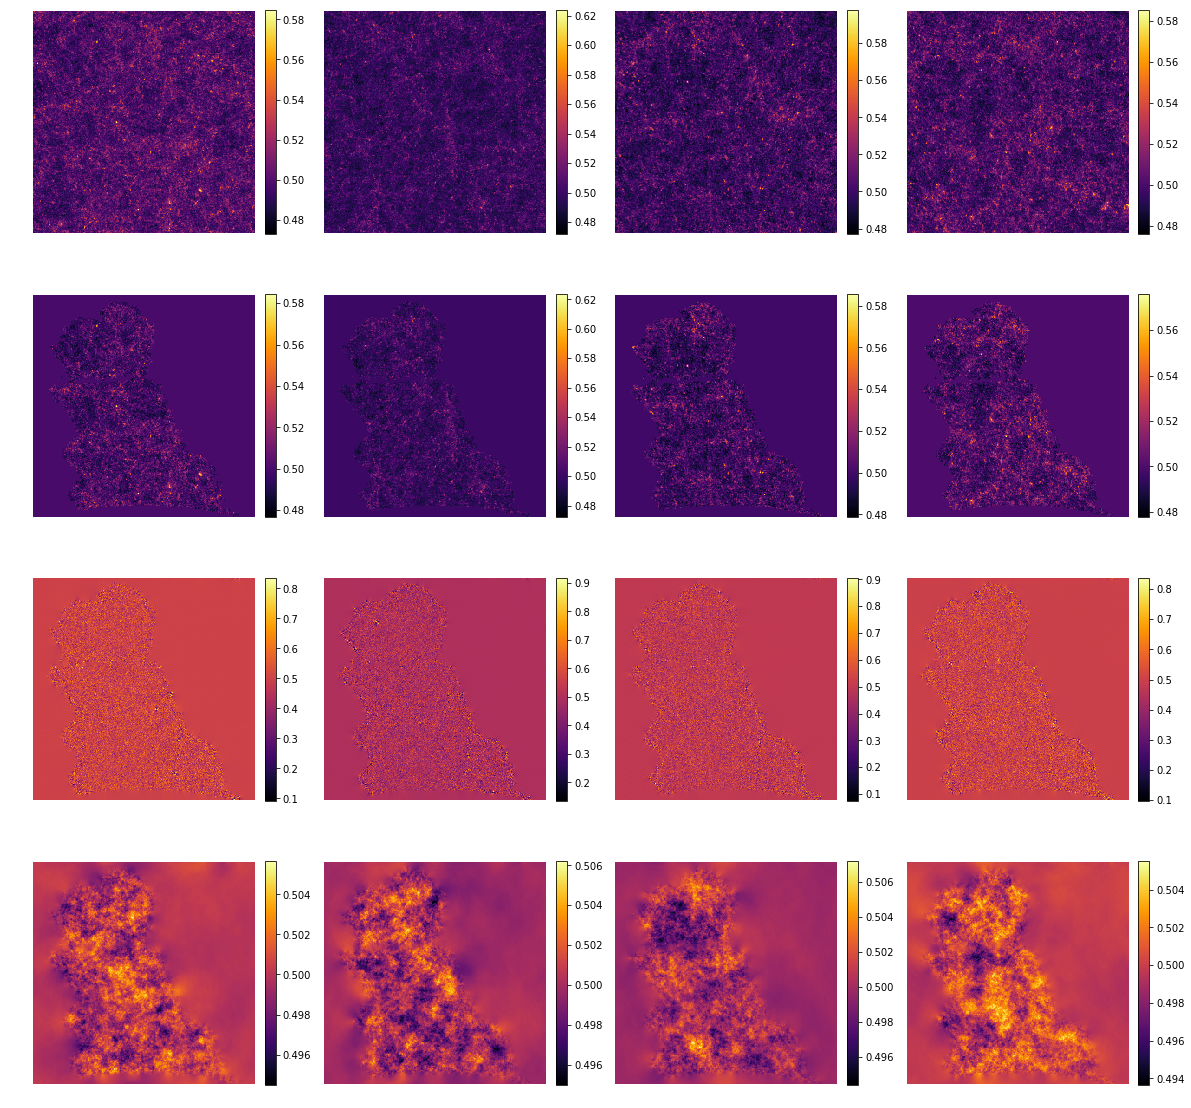

In [53]:
n = 4  # how many images displayed

plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    plt.subplot(4, n, i + 1)
    
    plt.imshow(mf.rescale_map(test_true[i,:,:,0], 1.0, 0.5), origin = 'lower', cmap = 'inferno')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + n)
    plt.imshow(mf.rescale_map(test_true[i,:,:,0]*sv_mask, 1.0, 0.5), origin = 'lower', cmap = 'inferno')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(mf.rescale_map(test_ks[i,:,:,0], 1., 0.5), cmap = 'inferno', origin = 'lower')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(mf.rescale_map(test_wiener[i,:,:,0], 1., 0.5), cmap = 'inferno', origin = 'lower')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    

plt.show()